<a href="https://colab.research.google.com/github/chrisdias/notebooks/blob/main/Austin_AirBnb_Price_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤔 Research Questions
* What are the features that most influence property pricing?
* What are the features that most influence property occupancy?
* What are the features that most influence property rating?
* What time of year has the highest rental prices?
* Is it worth it to be a superhost?
* Which neighborhoods are most successful at being Airbnbs?
* What is the average price per bedrooms / bathrooms?
* What should my property be priced at?
* How has all of this changed, over time? 
* Do we anticipate these changes to persist, post-COVID?

# Housekeeping

### Bringing in the data from the _Inside Airbnb_ website.

In [ ]:
# Bring in the data.
!wget http://data.insideairbnb.com/united-states/tx/austin/2021-02-10/visualisations/listings.csv
!wget http://data.insideairbnb.com/united-states/tx/austin/2021-02-10/visualisations/reviews.csv
!wget http://data.insideairbnb.com/united-states/tx/austin/2021-02-10/visualisations/neighbourhoods.csv
!wget http://data.insideairbnb.com/united-states/tx/austin/2021-02-10/visualisations/neighbourhoods.geojson
!wget http://data.insideairbnb.com/united-states/tx/austin/2021-02-10/data/calendar.csv.gz
!wget -O /content/reviews_big.csv.gz http://data.insideairbnb.com/united-states/tx/austin/2021-02-10/data/reviews.csv.gz
!wget -O /content/listings_big.csv.gz http://data.insideairbnb.com/united-states/tx/austin/2021-02-10/data/listings.csv.gz

In [ ]:
# Unzip files. Make sure to rename with *_big.
!gunzip /content/calendar.csv.gz
!gunzip /content/listings_big.csv.gz
!gunzip /content/reviews_big.csv.gz

In [ ]:
# Bring in the libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools

%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
# Create initial data frames.
listings = pd.read_csv('/content/listings.csv')
reviews = pd.read_csv('/content/reviews.csv')
neighbourhoods = pd.read_csv('/content/neighbourhoods.csv')
calendar = pd.read_csv('/content/calendar.csv')

In [ ]:
listings_big = pd.read_csv('/content/listings_big.csv')
reviews_big = pd.read_csv('/content/reviews_big.csv')

# Exploratory Data Analysis

### Preview the `listings` data to understand features.

Let's start with the `listings_big` dataframe:

In [ ]:
listings_big.columns

# Columns that might be of interest to visualize and consider:
# 
# - Host's response time, response rate, and acceptance rate.
# - Property type and room type.
# - Number accommodated, as well as number of bedrooms and bathrooms.
# - Included amenities.
# - Price per accommodation.

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [ ]:
import json

amenities_list = [json.loads(i) for i in listings_big.amenities]
amenities = []

for i in amenities_list:
  for j in i:
    if j not in amenities:
      amenities.append(j)
    else:
      continue

In [ ]:
set(amenities)

{'"everyone" soap 3 in 1 shampoo/body wash/bubble bath body soap',
 '"everyone" soap 3 in 1 shampoo/body wash/bubble bath shampoo',
 '32" HDTV with Amazon Prime Video, Netflix',
 '32" HDTV with Netflix, Roku',
 '32" TV with standard cable',
 '365 body soap',
 '365 conditioner',
 '4.6 cubic foot stainless steel refrigerator/freezer refrigerator',
 '40" HDTV with Chromecast',
 '40" HDTV with Netflix',
 '40" HDTV with Netflix, Amazon Prime Video',
 '40" HDTV with Netflix, premium cable, Amazon Prime Video',
 '40" HDTV with Roku',
 '40" TV',
 '40" TV with Netflix, Amazon Prime Video',
 '42" HDTV with Amazon Prime Video, HBO Max, Netflix, premium cable, Roku, standard cable',
 '42" HDTV with Amazon Prime Video, Netflix',
 '42" HDTV with Apple TV, Netflix, HBO Max',
 '42" TV with Netflix, standard cable',
 '42" TV with Roku, Netflix, Amazon Prime Video',
 '42" TV with standard cable, Netflix',
 '43" HDTV with Amazon Prime Video, Apple TV, HBO Max, Netflix',
 '48" HDTV with Apple TV',
 '49" H

In [ ]:
from collections import Counter

amenities_dict = Counter([item for elem in amenities_list for item in elem])
amenities_dict

Counter({'"everyone" soap 3 in 1 shampoo/body wash/bubble bath body soap': 1,
         '"everyone" soap 3 in 1 shampoo/body wash/bubble bath shampoo': 1,
         '32" HDTV with Amazon Prime Video, Netflix': 1,
         '32" HDTV with Netflix, Roku': 1,
         '32" TV with standard cable': 1,
         '365 body soap': 1,
         '365 conditioner': 1,
         '4.6 cubic foot stainless steel refrigerator/freezer refrigerator': 1,
         '40" HDTV with Chromecast': 2,
         '40" HDTV with Netflix': 1,
         '40" HDTV with Netflix, Amazon Prime Video': 1,
         '40" HDTV with Netflix, premium cable, Amazon Prime Video': 1,
         '40" HDTV with Roku': 1,
         '40" TV': 1,
         '40" TV with Netflix, Amazon Prime Video': 1,
         '42" HDTV with Amazon Prime Video, HBO Max, Netflix, premium cable, Roku, standard cable': 1,
         '42" HDTV with Amazon Prime Video, Netflix': 1,
         '42" HDTV with Apple TV, Netflix, HBO Max': 1,
         '42" TV with Netflix, 

In [ ]:
sns.countplot(

### Inspect and understand supplemental amenities.

In [ ]:
listings_big.amenities[0]

'["Free parking on premises", "Hair dryer", "Paid parking off premises", "Oven", "Stove", "Breakfast", "Dishes and silverware", "Air conditioning", "Microwave", "Extra pillows and blankets", "Long term stays allowed", "Hangers", "Dryer", "Washer", "Wifi", "Shampoo", "Carbon monoxide alarm", "Hot water", "Cooking basics", "Garden or backyard", "Smoke alarm", "Free street parking", "Refrigerator", "Iron", "Patio or balcony", "Lockbox", "Dedicated workspace", "Coffee maker", "Cable TV", "Essentials", "Bed linens", "Heating", "Private entrance", "TV", "Dishwasher", "Kitchen"]'

In [ ]:
# Obtain unique list of amenities for Airbnb properties.
#
# TODO webpaige@: include these items, or a subset of these items, as part of the 
# feature engineering for the Random Forest Regressor.

testdata = [ini_list.strip('][').split(', ') for ini_list in listings_big.amenities]
np.unique([*itertools.chain.from_iterable(testdata)])

array(['', '"32\\" HDTV with Amazon Prime Video',
       '"32\\" HDTV with Netflix', '"32\\" TV with standard cable"',
       '"365 body soap"', '"365 conditioner"',
       '"4.6 cubic foot stainless steel refrigerator/freezer refrigerator"',
       '"40\\" HDTV with Chromecast"', '"40\\" HDTV with Netflix',
       '"40\\" HDTV with Netflix"', '"40\\" HDTV with Roku"',
       '"40\\" TV with Netflix', '"40\\" TV"',
       '"42\\" HDTV with Amazon Prime Video', '"42\\" HDTV with Apple TV',
       '"42\\" TV with Netflix', '"42\\" TV with Roku',
       '"42\\" TV with standard cable',
       '"43\\" HDTV with Amazon Prime Video',
       '"48\\" HDTV with Apple TV"',
       '"49\\" HDTV with Amazon Prime Video',
       '"50\\" HDTV with Amazon Prime Video',
       '"50\\" HDTV with Chromecast', '"50\\" HDTV with Chromecast"',
       '"50\\" HDTV with Netflix', '"50\\" HDTV with Roku',
       '"50\\" HDTV with Roku"', '"50\\" HDTV"', '"50\\" TV with HBO Max',
       '"55\\" HDTV with Amazo

### Preview the review scores to understand data completeness / variance.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

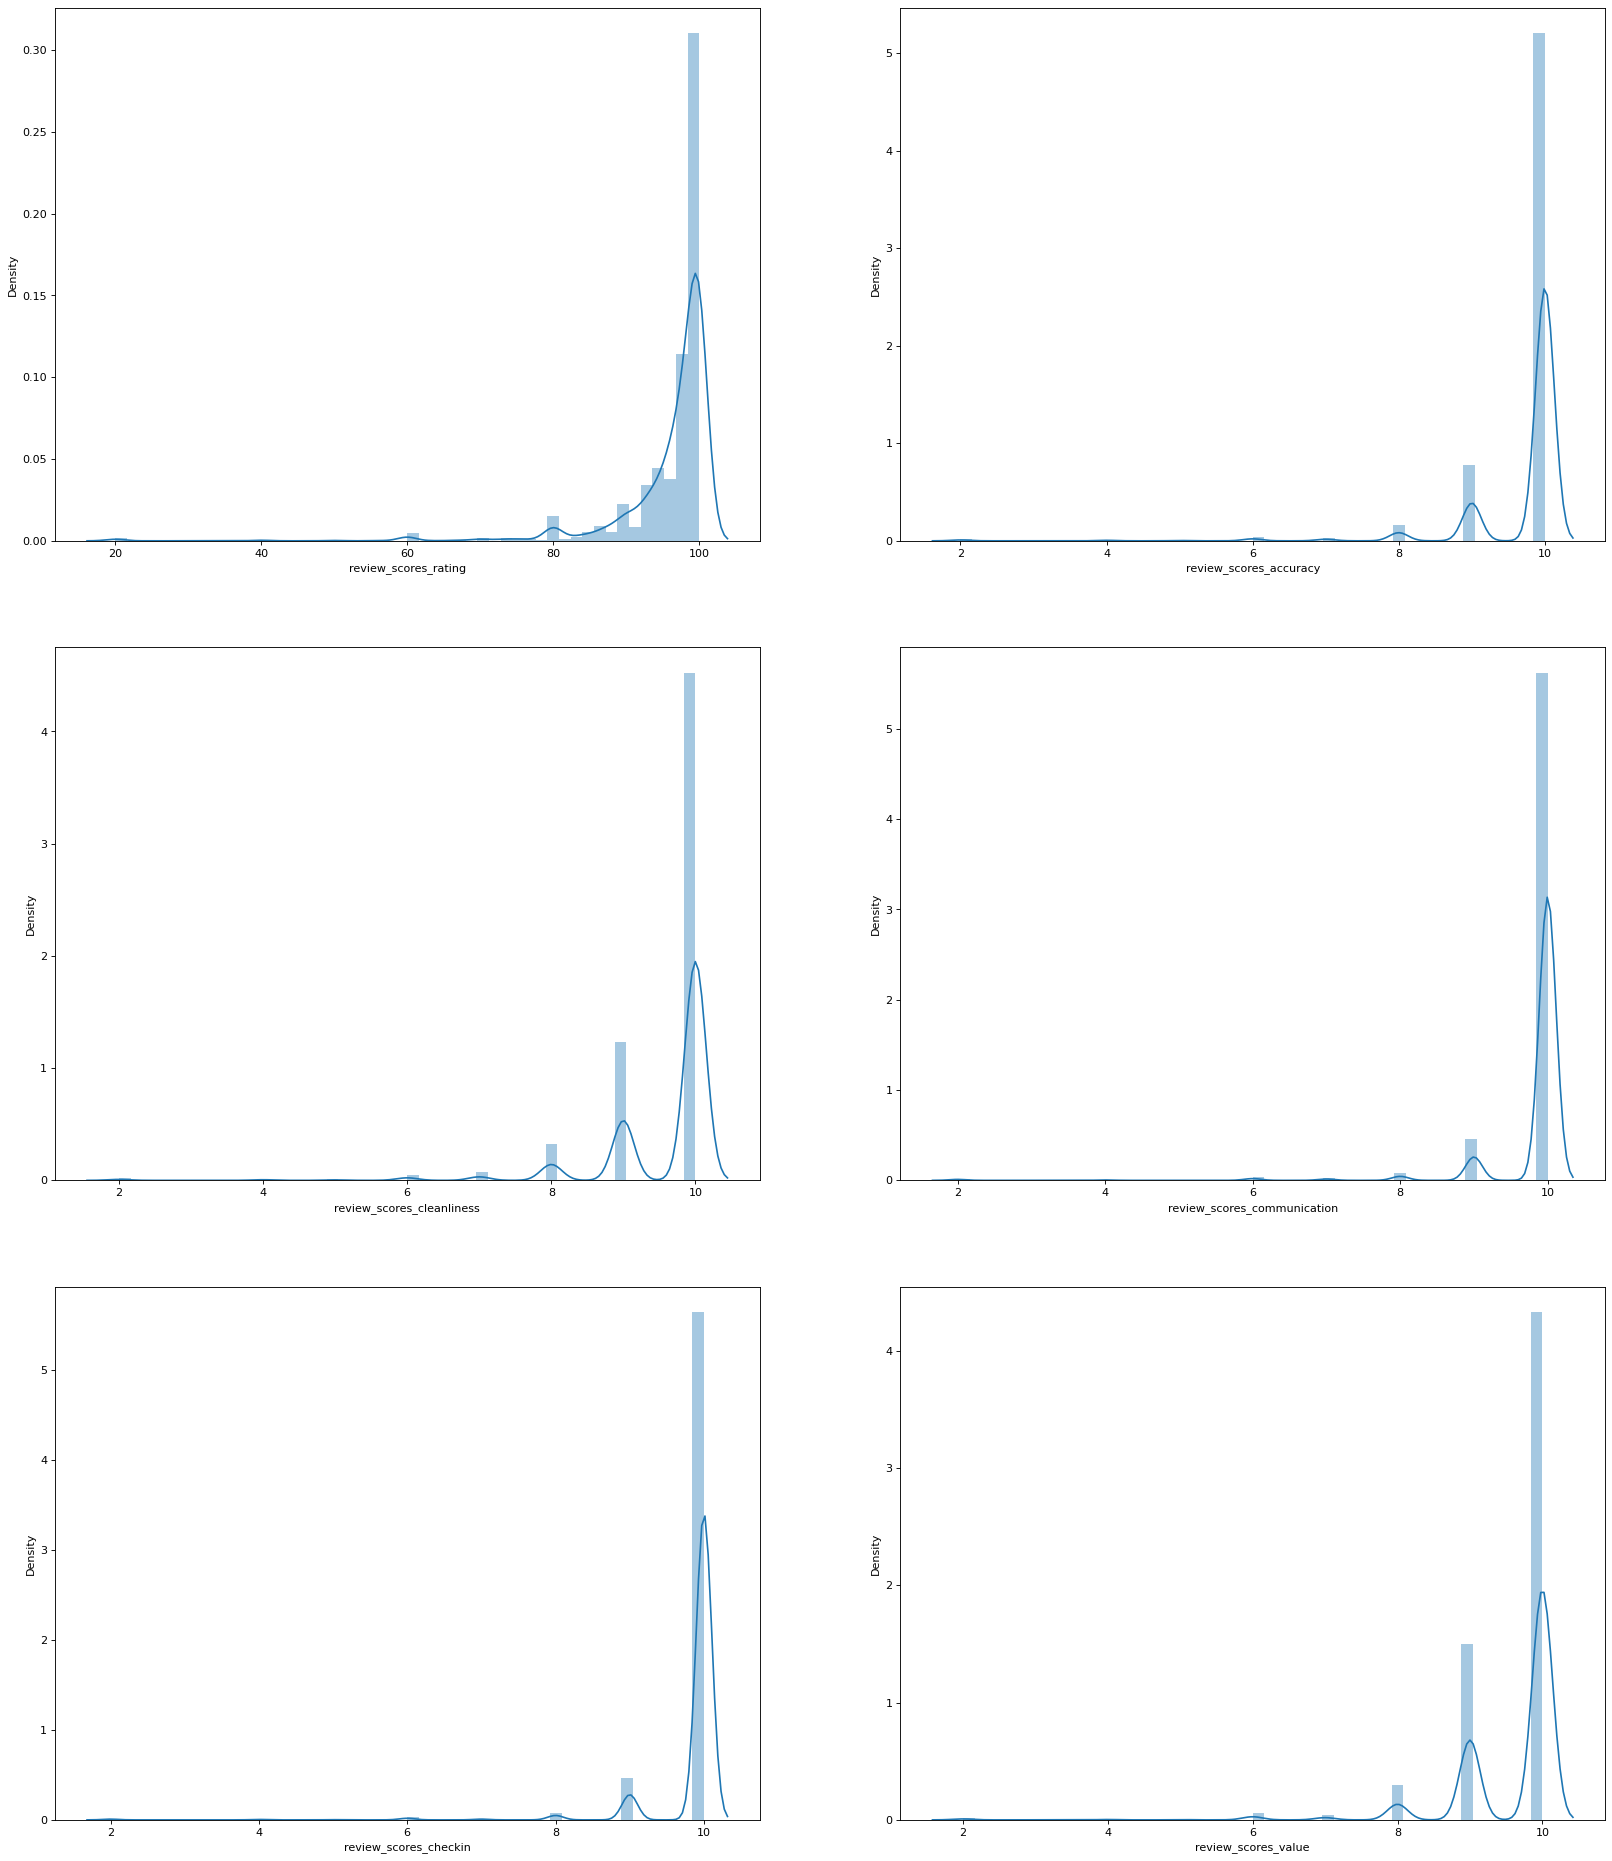

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(25, 30), dpi=80)

sns.distplot(listings_big["review_scores_rating"], ax=axs[0, 0])
sns.distplot(listings_big["review_scores_accuracy"], ax=axs[0, 1])
sns.distplot(listings_big["review_scores_cleanliness"], ax=axs[1, 0])
sns.distplot(listings_big["review_scores_communication"], ax=axs[1, 1])
sns.distplot(listings_big["review_scores_checkin"], ax=axs[2, 0])
sns.distplot(listings_big["review_scores_value"], ax=axs[2, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



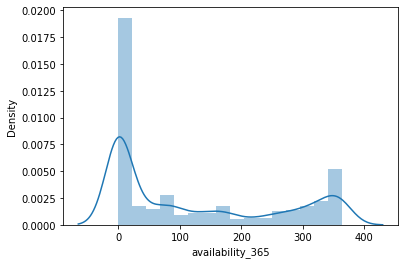

In [ ]:
# How many days of the year are properties vacant?
sns.distplot(listings_big.availability_365)
# sns.distplot(listings_big.availability_30)
# sns.distplot(listings_big.availability_60)
# sns.distplot(listings_big.availability_90)

# Cleaning

### Dealing with nonexistent values.

In [ ]:
# Backfill the host response rates.
listings_big['host_response_rate'].fillna(method = 'backfill', inplace = True)
listings_big['host_acceptance_rate'].fillna(method = 'backfill', inplace = True)
listings_big['host_response_time'].fillna(method = 'backfill', inplace = True)

In [ ]:
# Remove all columns that contain nothing other than NaNs.
listings_big.dropna(axis = 1, how = 'all', inplace = True)

In [ ]:
# Change percentage strings to numerics.
listings_big['host_response_rate'] = listings_big['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
listings_big['host_acceptance_rate'] = listings_big['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

(0.0, 1000.0)

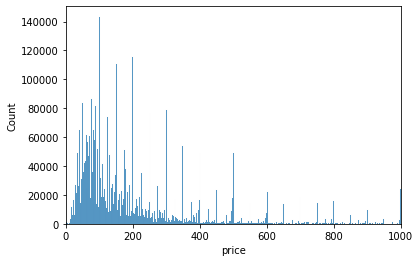

In [ ]:
# Change dollar value strings to numerics, and understand the distribution for
# properties priced at less than $1000.

sns.histplot(calendar.price.replace('[\$,]', '', regex=True).astype(float))
plt.xlim(0, 1000)

In [ ]:
listings_big['bathrooms'] = listings_big['bathrooms_text'].astype(str).str[0]

In [ ]:
listings_big.loc[(listings_big['bathrooms'] == 'n'), 'bathrooms'] = '0'
listings_big.loc[(listings_big['bathrooms'] == 'H'), 'bathrooms'] = '0'
listings_big.loc[(listings_big['bathrooms'] == 'P'), 'bathrooms'] = '0'

In [ ]:
listings_big.bathrooms = listings_big.bathrooms.astype(int)

In [ ]:
df_rooms = listings_big[["bathrooms", "bedrooms", "beds"]]

In [ ]:
listings_big["price"] = listings_big["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore')
listings_big["price"] = listings_big["price"].astype(float)
listings_big["price"].fillna(listings_big["price"].median(), inplace = True)

In [ ]:
for feature in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
                "review_scores_checkin", "review_scores_communication", "review_scores_location", 
                "review_scores_value", "reviews_per_month"]:
    listings_big[feature].fillna(listings_big[feature].mean(), inplace = True)

In [ ]:
# Create new dataframe selecting only the numerical columns
df_int = listings_big.select_dtypes(include=['int64', 'float64'])

# Add categorical columns to df_int
df_int[['superhost', 'room_type', 'neighbourhood_cleansed', 
        'property_type', 'host_response_time']] = listings_big[['host_is_superhost', 
                                                           'room_type', 'neighbourhood_cleansed', 
                                                          'property_type', 'host_response_time']]

In [ ]:
cleanup_nums = {"superhost":     {"t": 1, "f": 2},
                "room_type": {"Entire home/apt": 1, "Private room": 2, "Shared room": 3}}
df_int_copy = df_int
df_int_copy = df_int_copy.replace(cleanup_nums)

df_int_dummies = pd.get_dummies(df_int_copy)

### Additional data cleaning on `calendar` 

In [ ]:
calendar['month'] = calendar.date.apply(lambda value: value.split('-')[1])
calendar['month'] = calendar['month'].replace({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

calendar.dropna(axis = 0, subset = ["price"], inplace = True)
calendar["price"] = calendar["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore').astype(float)

calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,month
0,77635,2021-02-12,f,175.0,$175.00,2.0,1125.0,Feb
1,76925,2021-02-12,f,400.0,$400.00,2.0,8.0,Feb
2,76925,2021-02-13,f,400.0,$400.00,2.0,8.0,Feb
3,76925,2021-02-14,f,400.0,$400.00,2.0,8.0,Feb
4,76925,2021-02-15,f,400.0,$400.00,2.0,8.0,Feb


In [ ]:
df_int_dummies.replace([np.inf, -np.inf], np.nan)

df_int_dummies.dropna(inplace=True)

# Scikit-Learn Models: `RandomForestRegressor`, `DecisionTree`

## `RandomForestRegressor` and `LinearRegression` sans feature engineering.

MAE from RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False):121.94965802987862
MAE from LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False):167.98342784112242


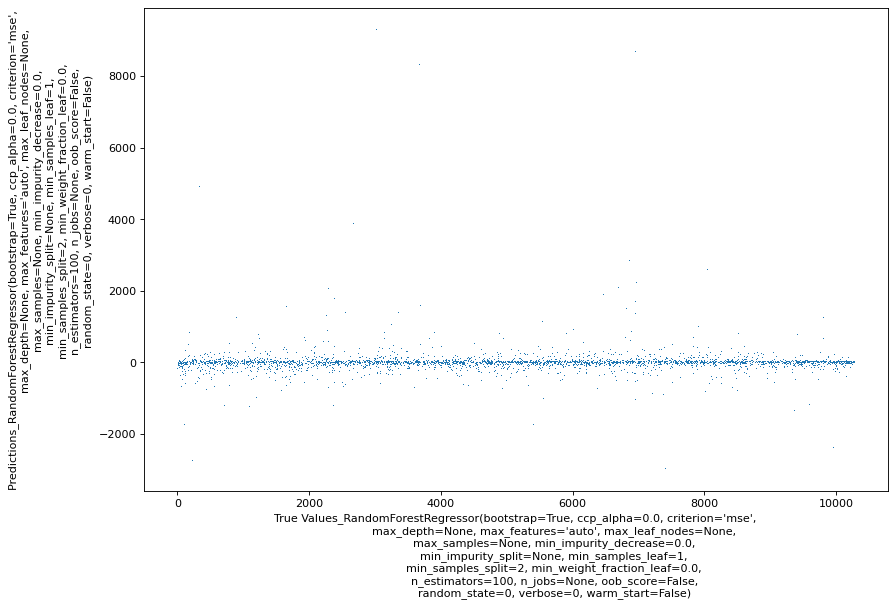

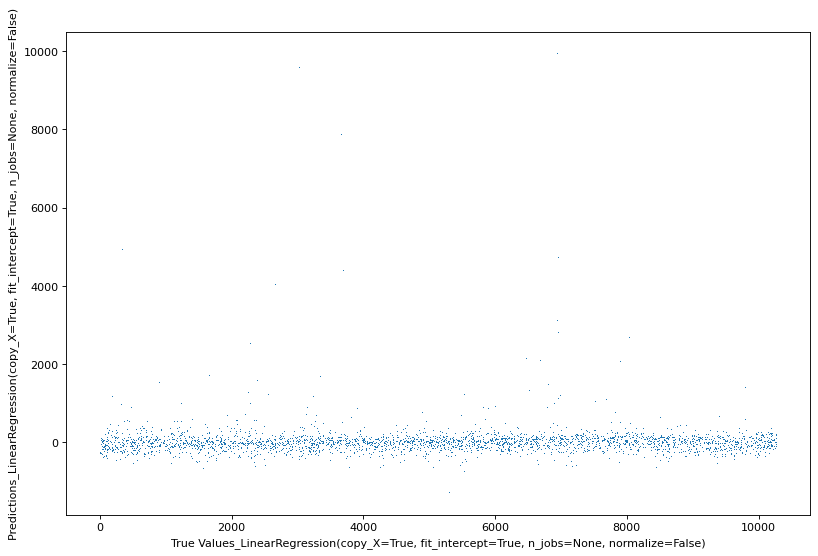

In [ ]:
#Assign target y variable and features X variable
y = df_int_dummies.price

X = df_int_dummies.drop(labels = ["price"], axis = 1)

#split test and train dataset from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#We will create a function to fit the model and evaluate
def model_evaluate(model, x_train, y_train, x_test, y_test):
    '''Input:
    model : define prediction algorithm that we want to apply
    x_train : training dataset with input features
    y_test: training data series for target variable
    x_test: validation dataset with input features
    y_test: validation data series for target variable
    
    1.) fit the model to training data set
    2.) predict the target variable for the validation data set
    3.) compare and evaluate the predicted target variable and actual target variable for the validation data set
    
    Output:
    1.) Mean absolute error for each model applied
    2.) scatter plot for the difference between actual and predicted target variable of the validation data set
    '''
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, pred)
    print("MAE from {0}:{1}".format(model, mae))
    fig = plt.figure(figsize=(12, 8), dpi=80)
    ax1 = fig.add_subplot(111)
    lines = plt.plot(y_test - pred,marker=',',linestyle='')
    ax1.set_xlabel('True Values_{}'.format(model))
    ax1.set_ylabel('Predictions_{}'.format(model))

# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=0)    
model_evaluate(model_rf, X_train, y_train, X_test, y_test)

# Linear Regression
model_lr = LinearRegression()
model_evaluate(model_lr, X_train, y_train, X_test, y_test)

In [ ]:
# Decision Tree
model_clf = DecisionTreeClassifier(max_leaf_nodes=25, random_state=0)
model_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=25,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
n_nodes = model_clf.tree_.node_count
children_left = model_clf.tree_.children_left
children_right = model_clf.tree_.children_right
feature = model_clf.tree_.feature
threshold = model_clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))

The binary tree structure has 49 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 38] <= 26.0 else to node 2.
	node=1 is a split node: go to node 5 if X[:, 42] <= 0.5 else to node 6.
	node=2 is a split node: go to node 3 if X[:, 10] <= 1.5 else to node 4.
		node=3 is a split node: go to node 33 if X[:, 0] <= 30677694.0 else to node 34.
		node=4 is a leaf node.
		node=5 is a split node: go to node 17 if X[:, 35] <= 16.0 else to node 18.
		node=6 is a split node: go to node 7 if X[:, 5] <= 2290.0 else to node 8.
			node=7 is a split node: go to node 13 if X[:, 10] <= 5.5 else to node 14.
			node=8 is a split node: go to node 9 if X[:, 62] <= 0.5 else to node 10.
				node=9 is a split node: go to node 11 if X[:, 21] <= 3.5 else to node 12.
				node=10 is a leaf node.
					node=11 is a leaf node.
					node=12 is a leaf node.
				node=13 is a split node: go to node 15 if X[:, 23] <= 0.5 else to node 16.
				node=14 is a split node: go to node 21 if X

In [ ]:
features = pd.DataFrame.from_dict(zip(df_int_dummies.columns, model_rf.feature_importances_))
features = features.sort_values(by = [1], ascending = False)
features.head(25)

# These are the features most correlated to price, sorted by importance.
#
# I'm a bit skeptical about this, though - obviously reviews per month would be
# correlated, as the more people you have renting, the more reviews you would 
# have. Same for the availability_* metrics.
#
# Am going to create a more curated data frame, and try another version of the
# random forest regressor to see if we can get better results. 

,0,1
40,reviews_per_month,0.163971
11,bedrooms,0.125534
9,longitude,0.067637
4,host_acceptance_rate,0.063907
0,id,0.056744
8,latitude,0.045150
10,accommodates,0.035498
33,review_scores_communication,0.027063
12,beds,0.026872
39,calculated_host_listings_count_shared_rooms,0.026738


## `RandomForestRegressor` with feature engineering.

In [ ]:
df_int_dummies_new = df_int_dummies[['host_response_rate',
                                     'host_acceptance_rate',
                                     'host_listings_count',
                                     'host_total_listings_count',
                                     'neighbourhood_cleansed',
                                     'accommodates',
                                     'bedrooms',
                                     'beds',
                                     'price',
                                     'minimum_nights',
                                     'review_scores_rating',
                                     'review_scores_accuracy',
                                     'review_scores_cleanliness',
                                     'review_scores_checkin',
                                     'review_scores_communication',
                                     'review_scores_location',
                                     'review_scores_value',
                                     'bathrooms']]


MAE from RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False):136.35917806767804


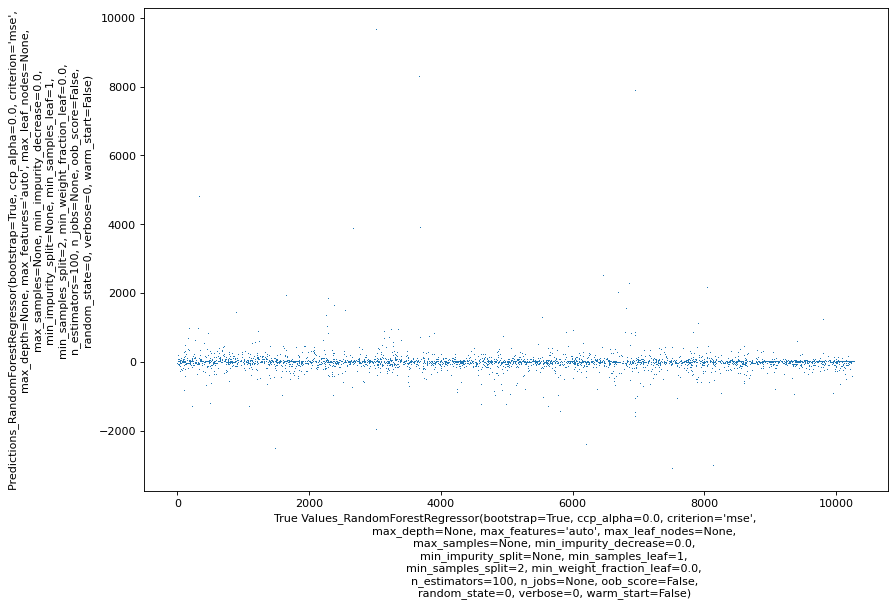

In [ ]:
#Assign target y variable and features X variable
y = df_int_dummies_new.price

X = df_int_dummies_new.drop(labels = ["price"], axis = 1)

#split test and train dataset from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#We will create a function to fit the model and evaluate
def model_evaluate(model, x_train, y_train, x_test, y_test):
    '''Input:
    model : define prediction algorithm that we want to apply
    x_train : training dataset with input features
    y_test: training data series for target variable
    x_test: validation dataset with input features
    y_test: validation data series for target variable
    
    1.) fit the model to training data set
    2.) predict the target variable for the validation data set
    3.) compare and evaluate the predicted target variable and actual target variable for the validation data set
    
    Output:
    1.) Mean absolute error for each model applied
    2.) scatter plot for the difference between actual and predicted target variable of the validation data set
    '''
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, pred)
    print("MAE from {0}:{1}".format(model, mae))
    fig = plt.figure(figsize=(12, 8), dpi=80)
    ax1 = fig.add_subplot(111)
    lines = plt.plot(y_test - pred,marker=',',linestyle='')
    ax1.set_xlabel('True Values_{}'.format(model))
    ax1.set_ylabel('Predictions_{}'.format(model))

# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=0)    
model_evaluate(model_rf, X_train, y_train, X_test, y_test)

# 💰 Feature Impact on Price

Which features are most likely to influence pricing for an Airbnb?

* `TODO: webpaige@`: Does feature importance change, by neighborhood?
* `TODO: webpaige@`: Are some amenities more successful in a given neighborhood?
* `TODO: webpaige@`: All other things equal, is it worthwhile to invest in amenities, or certain kinds of amenities?

**NOTE**: make sure to also do this with the `listings_big.amenities` items, after cleaning values.

In [ ]:
features = pd.DataFrame.from_dict(zip(df_int_dummies_new.columns, model_rf.feature_importances_))
features = features.sort_values(by = [1], ascending = False)
features.head(25)

,0,1
16,review_scores_value,0.179450
6,bedrooms,0.135429
1,host_acceptance_rate,0.122431
8,price,0.113315
4,neighbourhood_cleansed,0.086820
5,accommodates,0.075097
7,beds,0.066836
3,host_total_listings_count,0.050541
2,host_listings_count,0.047255
9,minimum_nights,0.025847


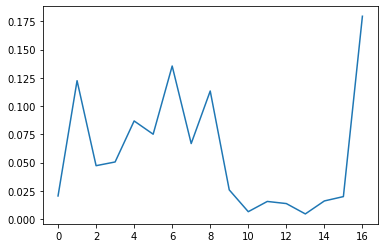

In [ ]:
plt.plot(model_rf.feature_importances_)
feature_importance_rf = zip(df_int_dummies.columns, model_rf.feature_importances_)

In [ ]:
df_int.groupby(['room_type']).count()

,id,scrape_id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms,superhost,property_type,host_response_time
room_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Entire home/apt,7962,7962,7962,7961,7962,7959,7959,7962,7962,7962,7962,7329,7934,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7962,7959,7962,7961
Hotel room,11,11,11,11,11,11,11,11,11,11,11,9,9,11,11,11,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
Private room,2166,2166,2166,2166,2166,2164,2164,2166,2166,2166,2166,2106,2137,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2166,2164,2166,2166
Shared room,133,133,133,133,133,133,133,133,133,133,133,133,129,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133


# ✨📊 Data visualizations and observations

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



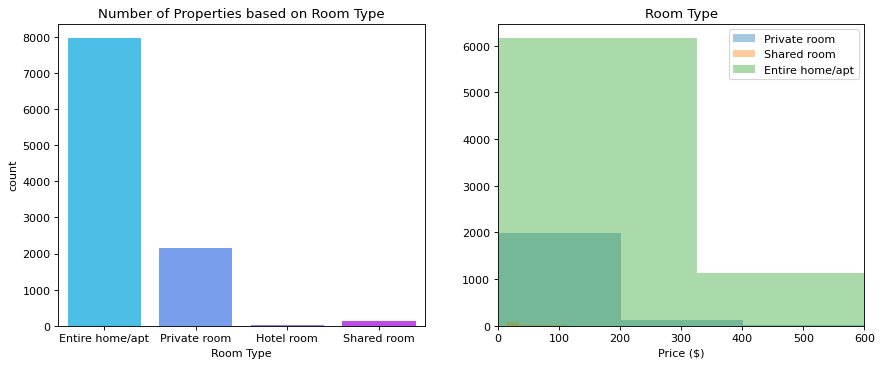

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), dpi=80)
sns.countplot(x = 'room_type', data = df_int, 
              palette = 'cool', ax=axs[0]).set_title("Number of Properties based on Room Type")
axs[0].set_xlabel('Room Type')


sns.distplot(df_int[df_int.room_type == 'Private room']['price'],
             kde=False, ax=axs[1], label='Private room')
sns.distplot(df_int[df_int.room_type == 'Shared room']['price'],
             kde=False, ax=axs[1], label='Shared room')
sns.distplot(df_int[df_int.room_type == 'Entire home/apt']['price'],
             kde=False, ax=axs[1], label='Entire home/apt')

axs[1].set_xlim(0, 600)
axs[1].set_title('Room Type')
axs[1].set_xlabel('Price ($)')
axs[1].legend()

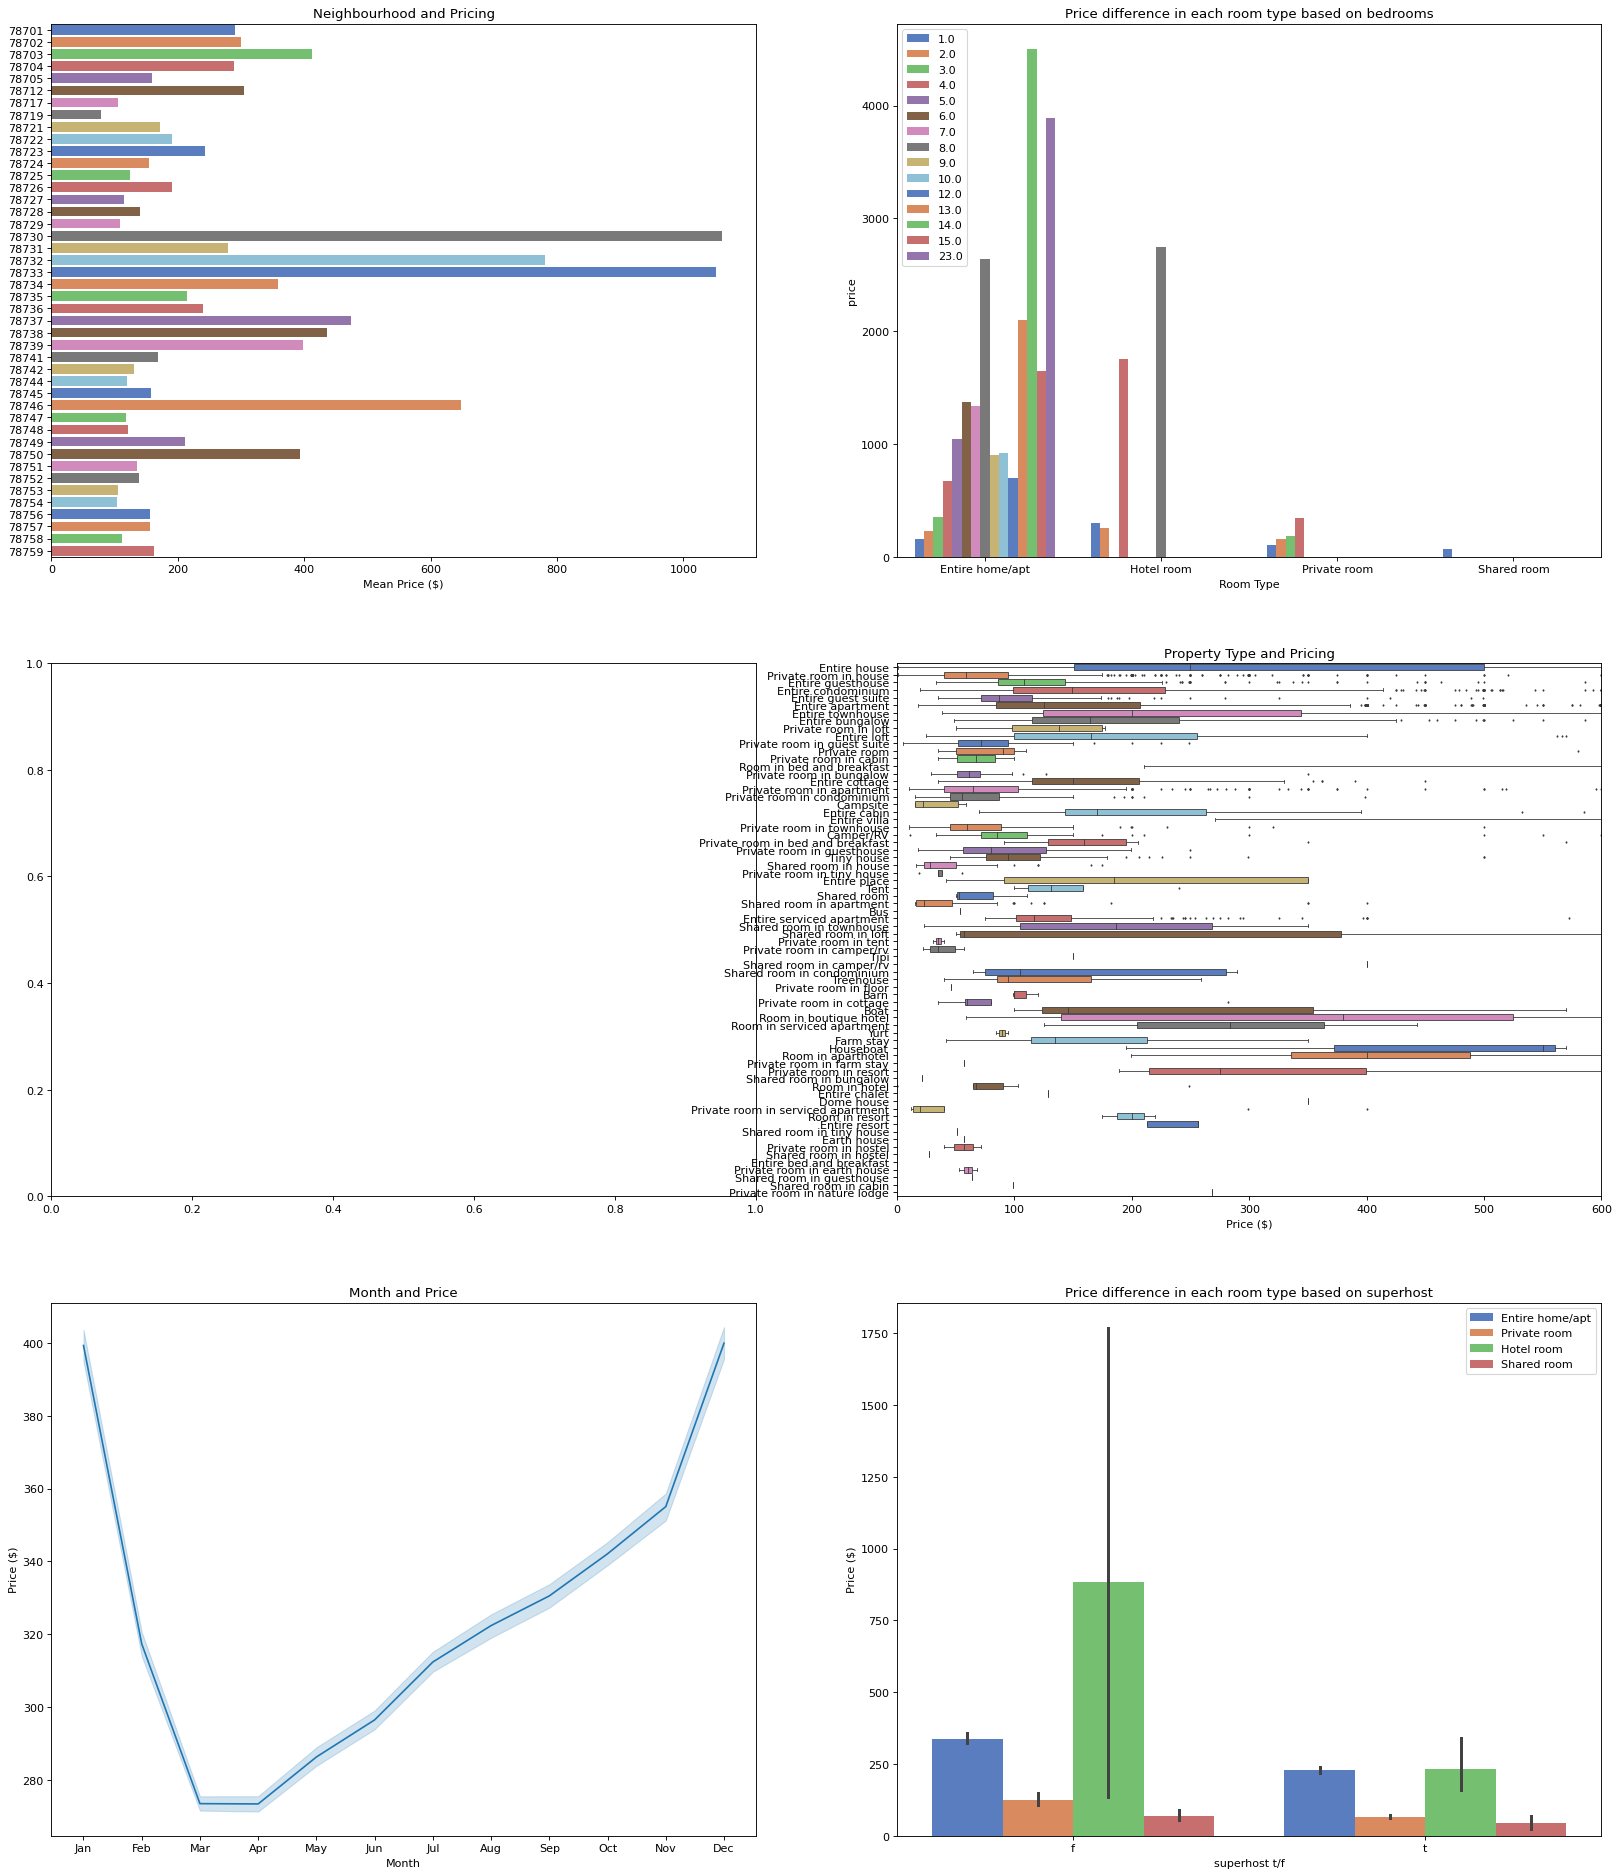

<Figure size 720x360 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(25, 30), dpi=80)

df_roomtype = df_int.groupby(['room_type', 'bedrooms'], as_index = False).mean()

neighbourhoods = df_int.groupby('neighbourhood_cleansed').agg(
    {
        'price': np.mean
    }
).reset_index()
sns.barplot(
    x='price', y='neighbourhood_cleansed',
    data=neighbourhoods.sort_values('price'),
    orient='h',
    palette='muted',
    ax=axs[0, 0]
)
axs[0, 0].set_title('Neighbourhood and Pricing')
axs[0, 0].set_xlabel('Mean Price ($)')
axs[0, 0].set_ylabel('')

sns.barplot(x="room_type", y="price", hue= 'bedrooms', data= df_roomtype, 
            palette= 'muted', ax=axs[0, 1])

axs[0, 1].set_title('Price difference in each room type based on bedrooms')
axs[0, 1].set_xlabel('Room Type')
axs[0, 1].legend()

sns.boxplot(x='price', y='property_type', fliersize=1, linewidth=0.75,
            data=df_int, palette='muted', ax=axs[1, 1])
axs[1, 1].set_xlim(0, 600)
axs[1, 1].set_title('Property Type and Pricing')
axs[1, 1].set_xlabel('Price ($)')
axs[1, 1].set_ylabel('')


cats = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
calendar['month'] = pd.Categorical(calendar['month'], ordered=True, categories=cats)

plt.figure(figsize=(10,5))

sns.lineplot(data = calendar, x = "month", y = "price", sort=True, ax = axs[2,0])

axs[2, 0].set_title("Month and Price")
axs[2, 0].set_xlabel('Month')
axs[2, 0].set_ylabel('Price ($)')


#Superhost
sns.barplot(x="superhost", y="price", hue= 'room_type', data= df_int, 
            palette= 'muted', ax=axs[2, 1])

axs[2, 1].set_title('Price difference in each room type based on superhost')
axs[2, 1].set_xlabel('superhost t/f')
axs[2, 1].set_ylabel('Price ($)')
axs[2, 1].legend()


plt.tight_layout()
plt.show();

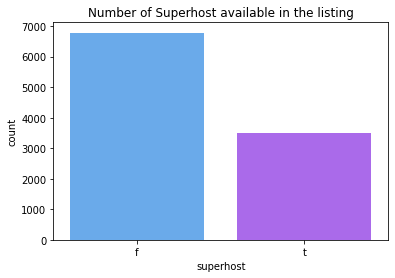

In [ ]:
ax1 = sns.countplot(x="superhost", data=df_int, palette = 'cool').set_title("Number of Superhost available in the listing")

In [ ]:
grp_res = df_int.groupby(['superhost', 'host_response_time']).size()
grp_host = df_int.groupby(['superhost']).size()
grp_res_mean = grp_res/grp_host
#Reset index
grp_res_mean = grp_res_mean.reset_index(name='counts')
grp_res_mean

,superhost,host_response_time,counts
0,f,a few days or more,0.053803
1,f,within a day,0.105985
2,f,within a few hours,0.146079
3,f,within an hour,0.693986
4,t,a few days or more,0.006604
5,t,within a day,0.052541
6,t,within a few hours,0.136664
7,t,within an hour,0.804192


In [ ]:
px.bar(grp_res_mean, x="superhost", y="counts", color="host_response_time",
            hover_data=['host_response_time'], barmode = 'stack', width=650, height=450,
      title="Average response time per host type")

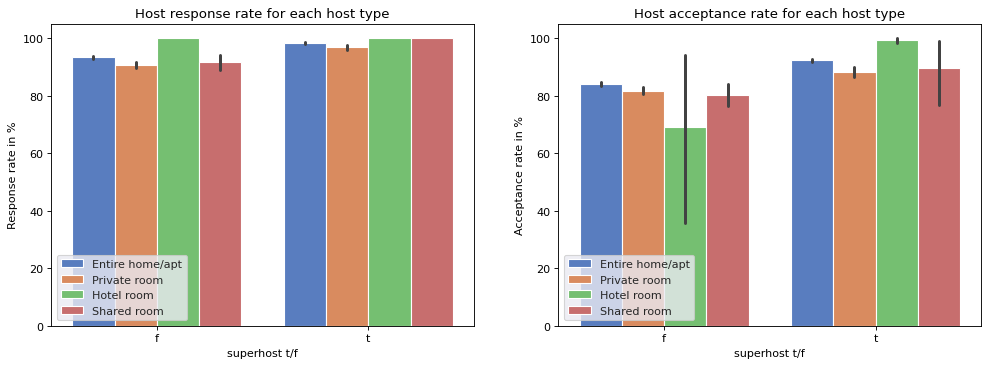

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=80)
sns.set_style(style="darkgrid")

sns.barplot(x="superhost", y="host_response_rate", hue= 'room_type', data= df_int, 
            palette= 'muted', ax=axs[0])

axs[0].set_title('Host response rate for each host type')
axs[0].set_xlabel('superhost t/f')
axs[0].set_ylabel('Response rate in %')
axs[0].legend()

sns.barplot(x="superhost", y="host_acceptance_rate", hue= 'room_type', data= df_int, 
            palette= 'muted', ax=axs[1])

axs[1].set_title('Host acceptance rate for each host type')
axs[1].set_xlabel('superhost t/f')
axs[1].set_ylabel('Acceptance rate in %')
axs[1].legend()

In [ ]:
df_host_review = df_int.groupby(['superhost']).mean()

df_host_review[["number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
               "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value",
               "reviews_per_month"]]

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
superhost,,,,,,,,,
f,14.646374,94.996489,9.658713,9.469059,9.791152,9.773577,9.718625,9.467767,0.961859
t,65.005455,97.823672,9.910256,9.813483,9.955119,9.951942,9.884482,9.783605,1.900838


Text(0.5, 1.0, 'Average Review Score for Rooms with and without a Superhost')

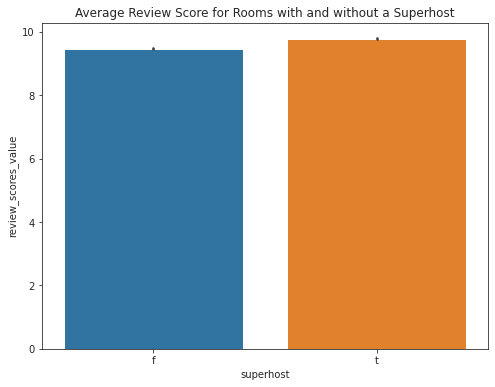

In [ ]:
sns.set_style("ticks")
plt.figure(figsize=(8, 6))
sns.barplot(x = 'superhost', y = 'review_scores_value', data = df_int).set_title("Average Review Score for Rooms with and without a Superhost")

<Figure size 864x432 with 0 Axes>

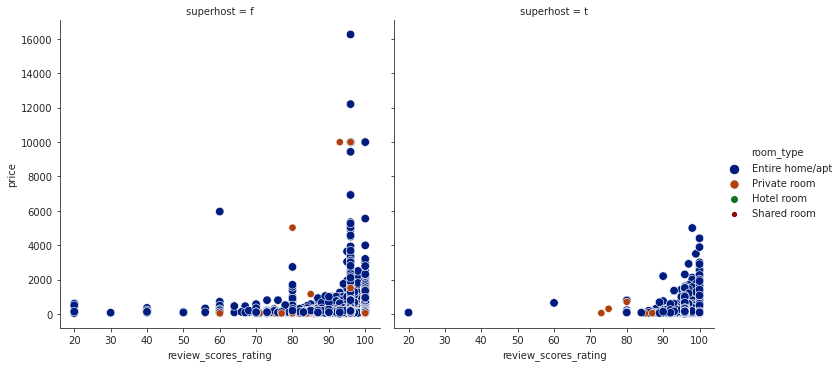

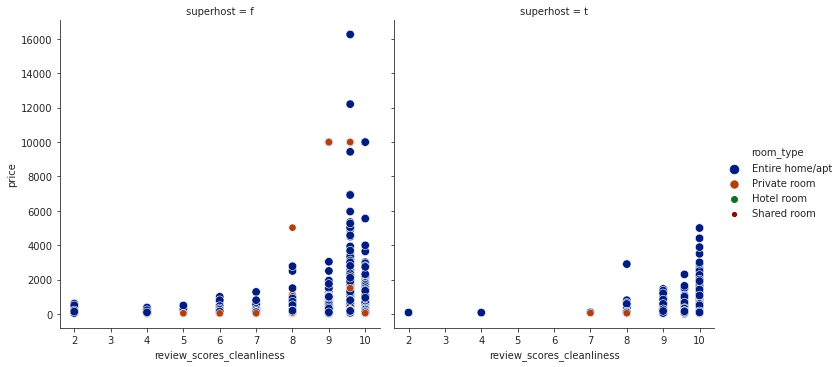

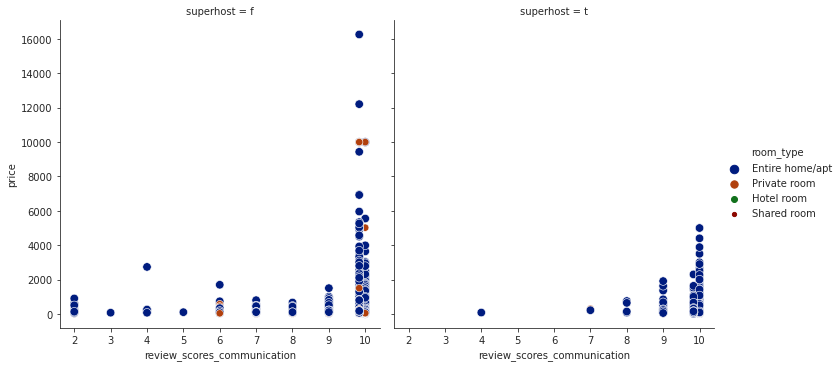

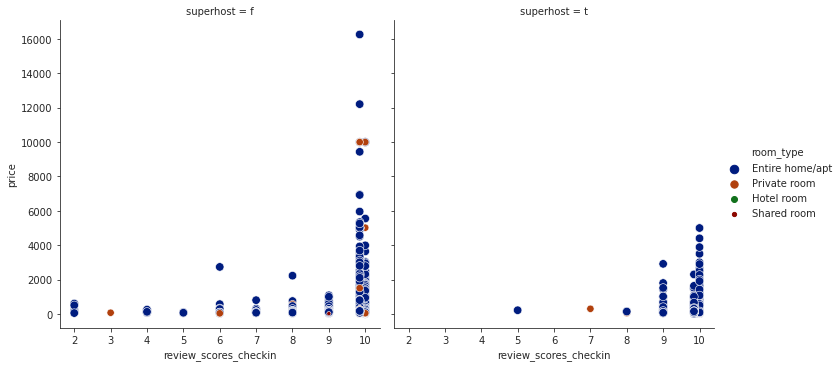

In [ ]:
sns.set_style("ticks")
plt.figure(figsize=(12, 6))

sns.relplot(x = 'review_scores_rating', y = 'price', data = df_int, kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = 'dark')

sns.relplot(x = 'review_scores_cleanliness', y = 'price', data = df_int, kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = 'dark')

sns.relplot(data=df_int, x= 'review_scores_communication', y="price", kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = "dark")

sns.relplot(data=df_int, x= 'review_scores_checkin', y="price", kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = "dark")